# Project : Stock Price Prediction
The objective of this project is to accurately predict the  Adjusted closing value of a given stock across a given period of time.

The price of a stock can be modeled by a continuous stochastic process which is the sum between a predictable and an unpredictable part. Therefore I have used combination of Linear Regression {for modelling predictable part} and SVR { for modelling unpredictable part}.


### Importing Libraries

In [25]:
import pandas as pd
import datetime
from pandas_datareader import data, wb
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Function to get historical data of any stocks, from Yahoo Finance.

In [26]:
def get_historical_data(symbol,start_date,end_date):
    
    ''' Daily quotes from Yahoo Finance. Date format='yyyy-mm-dd'
        symbol : stock symbol eg: GOOGL, FB , AAPL
        start_date, end _date =  period for which, data is required     
    '''
    symbol = symbol.upper()
    start = datetime.date(int(start_date[0:4]), int(start_date[5:7]), int(start_date[8:10]))
    end = datetime.date(int(end_date[0:4]), int(end_date[5:7]), int(end_date[8:10]))
    return data.DataReader(symbol, 'yahoo', start, end)

## Function to model stock price using SVR model
In this particular project I have used previous 3 years data to predict future values.

In [27]:
def get_prediction_linear(stock,start_date,end_date):
    
    '''
    stock : stock symbol eg: GOOGL, FB , AAPL
    start_date, end_date : period for which prediction is required
    Date format='yyyy-mm-dd'
    
    '''
    
    start_date = datetime.date(int(start_date[0:4]), int(start_date[5:7]), int(start_date[8:10]))
    end_date = datetime.date(int(end_date[0:4]), int(end_date[5:7]), int(end_date[8:10]))
    prediction_days = np.busday_count(start_date,end_date)
    train_start=(start_date +datetime.timedelta(-3*365)).strftime("%Y/%m%d")
    train_end=(start_date +datetime.timedelta(-1)).strftime("%Y/%m%d")
    
               
    df = get_historical_data(stock,train_start,train_end)    
    alpha=(df.index[0]).date()

    df=df.reset_index()
    df['Date']=df['Date'].apply(lambda x:(x.date()-alpha).days)
    X_train=df[['Date']]
    y_train=df[['Adj Close']]
    y_train=pd.DataFrame(data=np.array(y_train['Adj Close']),columns=y_train.columns,index=X_train['Date'])
    
    from sklearn.linear_model import LinearRegression
    classifier = LinearRegression()
    classifier.fit(X_train, y_train)
    
    clf_prediction = classifier.predict(X_train)
    clf_prediction_train=pd.DataFrame(data=clf_prediction,columns=y_train.columns,index=X_train['Date'])
    
    actual=get_historical_data(stock,(start_date).strftime("%Y/%m%d"),(end_date).strftime("%Y/%m%d"))
    actual=actual.reset_index()
    actual['Date']=actual['Date'].apply(lambda x:(x.date()-alpha).days)
    x_predict=actual[['Date']]
    y_actual=pd.DataFrame(data=np.array(actual['Adj Close']),columns=y_train.columns,index=x_predict['Date'])
    
    
    clf_prediction = classifier.predict(x_predict)    
    clf_prediction_test=pd.DataFrame(data=clf_prediction,columns=y_train.columns,index=x_predict['Date']) 
    
    plt.figure(figsize=[15,5])
    plt.plot(y_train,'r',label="Y_train")
    plt.plot(clf_prediction_train,'b',label="Predicted")
    plt.title(f"{stock} Linear Part for Train Data")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=[15,5])
    plt.plot(y_actual,'r',label="Y_actual")
    plt.plot(clf_prediction_test,'b',label="Predicted")
    plt.title(f"{stock} Linear Part for Test Data")
    plt.legend()
    plt.show()
    
   
    return y_train-clf_prediction_train,y_actual-clf_prediction_test,clf_prediction_train,clf_prediction_test,y_actual,y_train

In [31]:
def stochastic_part(stock,start_date,end_date):
    
    df_train,df_test,linear_part_train,linear_part_test,y_actual,y_train=get_prediction_linear(stock,start_date,end_date)
    X_train=df_train.reset_index()[['Date']]
    y_train=df_train[['Adj Close']]
    X_test=df_test.reset_index()[['Date']]
    y_test=df_test[['Adj Close']]
    
    from sklearn.svm import SVR
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.00001)
    
    svr_rbf.fit(X_train, y_train)
    stochastic_test=svr_rbf.predict(X_test)
    stochastic_train=svr_rbf.predict(X_train)
    
    stochastic_test=pd.DataFrame(stochastic_test,columns=y_test.columns,index=df_test.index)
    stochastic_train=pd.DataFrame(stochastic_train,columns=y_train.columns,index=df_train.index)
    
    plt.figure(figsize=[15,5])
    plt.plot(y_train,'r',label="Y_train")
    plt.plot(stochastic_train,'b',label="Predicted")
    plt.title(f"{stock} Stochastic Part for Train Data")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=[15,5])
    plt.plot(y_test,'r',label="Y_actual")
    plt.plot(stochastic_test,'b',label="Predicted")
    plt.title(f"{stock} Stochastic Part for Test Data")
    plt.legend()
    plt.show()
    
    return stochastic_test,stochastic_train

In [37]:
def stock_price_prediction(stock,start_date,end_date):
    
    df_train,df_test,linear_part_train,linear_part_test,y_actual,y_train=get_prediction_linear(stock,start_date,end_date)
    stochastic_test,stochastic_train = stochastic_part(stock,start_date,end_date)
    
    stock_price_train = linear_part_train+stochastic_train
    stock_price_test = linear_part_test+stochastic_test
    actual_price = y_actual
    
    plt.figure(figsize=[15,5])
    plt.plot(y_train,'r',label="Y_train")
    plt.plot(stock_price_train,'b',label="Predicted")
    plt.title(f"{stock} Stock Price Prediction for Train Data")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=[15,5])
    plt.plot(y_actual,'r',label="Y_actual")
    plt.plot(stock_price_test,'b',label="Predicted")
    plt.title(f"{stock} Stock Price Prediction for Test Data")
    plt.legend()
    plt.show()
    

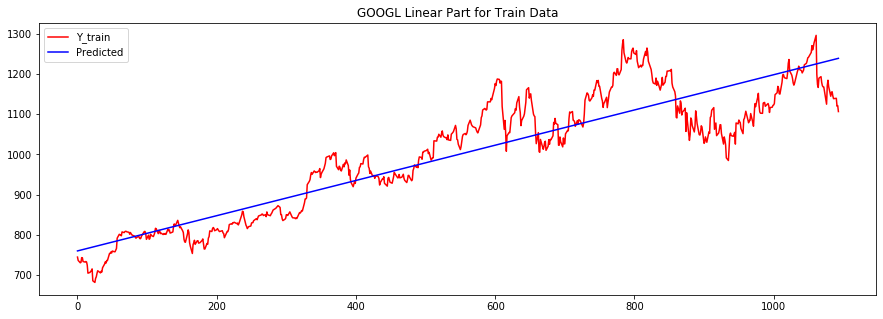

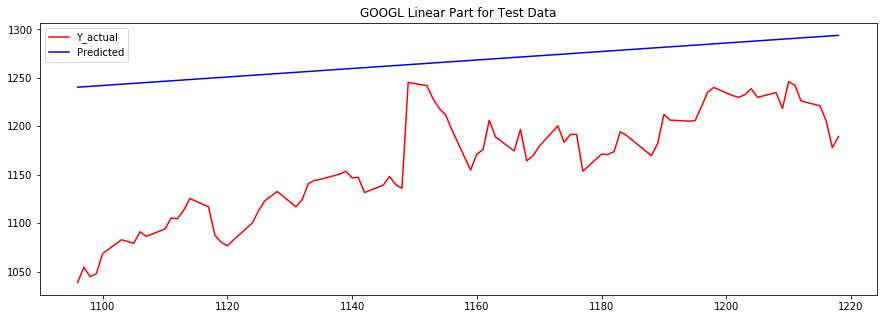

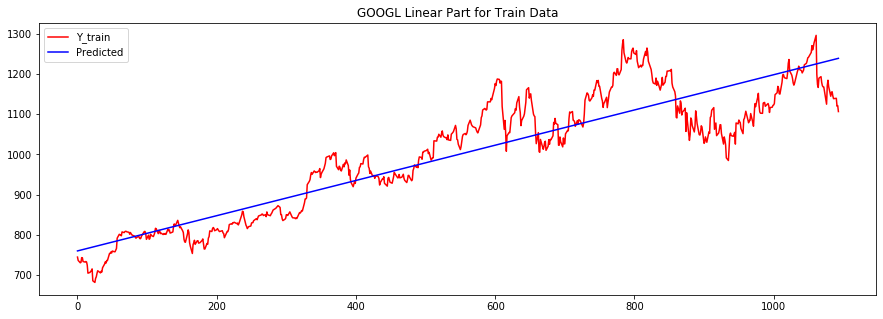

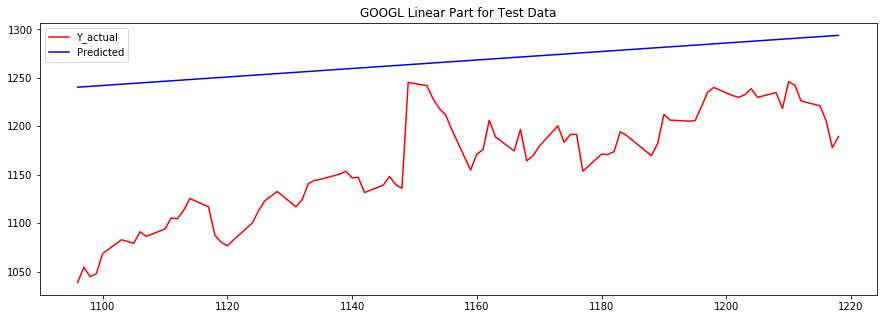

C:\Users\priyanshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


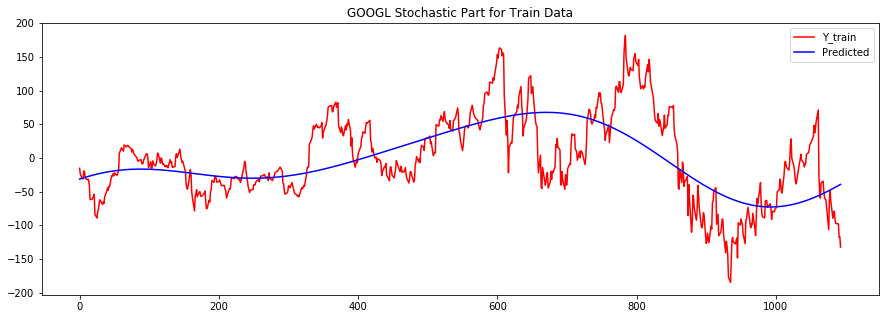

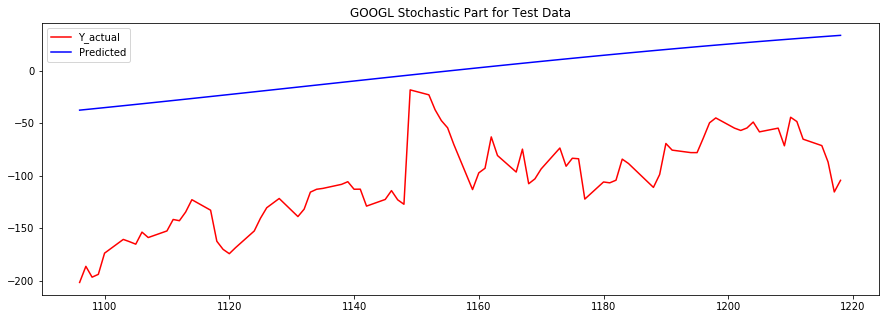

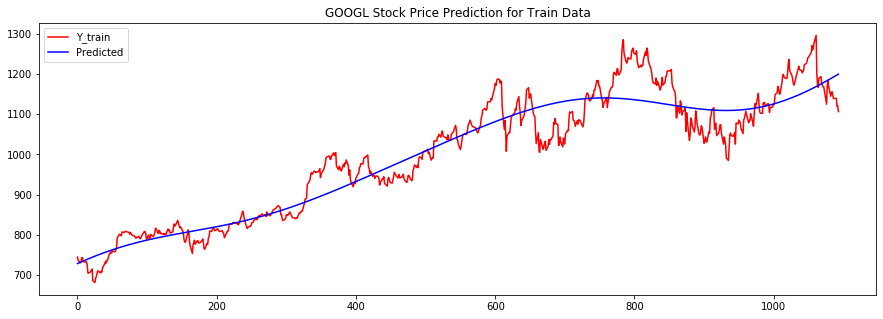

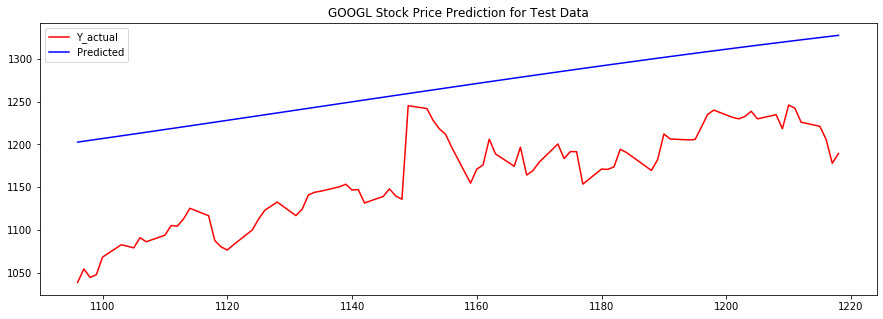

In [38]:
stock_price_prediction('GOOGL','2019/06/03','2019/10/03')